Trained 50 trees...
Trained 100 trees...
Trained 150 trees...
Trained 200 trees...
Trained 250 trees...
Trained 300 trees...
Trained 350 trees...
Trained 400 trees...
Trained 450 trees...
Trained 500 trees...


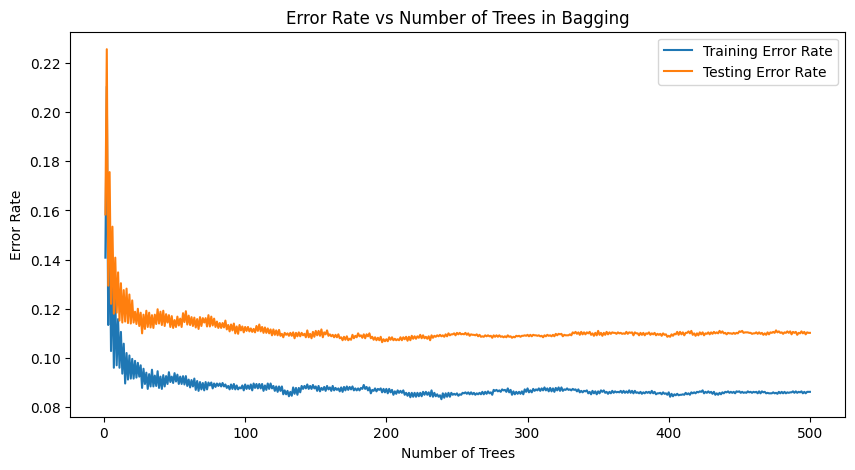

In [18]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Create a tree node with initialized attributes
def initialize_node(data=None):
    return {'data': data, 'left_branch': None, 'right_branch': None, 'attribute': None, 'split_value': None}

# Check if the node is a terminal (leaf) node
def check_leaf_node(node):
    return node['data'] is not None

# Identify the types of features, whether they are categorical or numerical
def find_feature_types(features):
    feature_types = []
    for i in range(features.shape[1]):
        distinct_values = np.unique(features[:, i])
        if isinstance(distinct_values[0], (int, float)) and len(distinct_values) > 10:
            feature_types.append("numerical")
        else:
            feature_types.append("categorical")
    return feature_types

# Split the dataset based on a specific attribute and threshold
def divide_dataset(features, attribute, threshold):
    left_subset = np.where(features[:, attribute] <= threshold)[0]
    right_subset = np.where(features[:, attribute] > threshold)[0]
    return left_subset, right_subset

# Calculate the entropy, a measure of uncertainty or disorder in the labels
def compute_entropy(labels):
    label_counts = Counter(labels)
    total = len(labels)
    entropy_result = 0.0
    for count in label_counts.values():
        prob = count / total
        if prob > 0:
            entropy_result -= prob * np.log2(prob)
    return entropy_result

# Calculate the information gain after splitting
def info_gain(original_labels, left_labels, right_labels):
    total_instances = len(original_labels)
    original_entropy = compute_entropy(original_labels)
    left_entropy = compute_entropy(left_labels)
    right_entropy = compute_entropy(right_labels)
    weighted_entropy = (len(left_labels) / total_instances) * left_entropy + (len(right_labels) / total_instances) * right_entropy
    return original_entropy - weighted_entropy

# Determine the best attribute and threshold to split the data
def optimal_split(features, labels, feature_types, threshold_options=10):
    max_gain = -np.inf
    optimal_attribute = None
    optimal_threshold = None
    num_attributes = features.shape[1]

    for attribute in range(num_attributes):
        if feature_types[attribute] == "numerical":
            distinct_values = np.unique(features[:, attribute])
            if len(distinct_values) > threshold_options:
                thresholds = np.quantile(distinct_values, np.linspace(0, 1, threshold_options + 2)[1:-1])
            else:
                thresholds = distinct_values

            for threshold in thresholds:
                left_subset, right_subset = divide_dataset(features, attribute, threshold)
                if len(left_subset) == 0 or len(right_subset) == 0:
                    continue
                gain = info_gain(labels, labels[left_subset], labels[right_subset])
                if gain > max_gain:
                    max_gain = gain
                    optimal_attribute = attribute
                    optimal_threshold = threshold
        else:
            distinct_values = np.unique(features[:, attribute])
            for value in distinct_values:
                left_subset, right_subset = divide_dataset(features, attribute, value)
                if len(left_subset) == 0 or len(right_subset) == 0:
                    continue
                gain = info_gain(labels, labels[left_subset], labels[right_subset])
                if gain > max_gain:
                    max_gain = gain
                    optimal_attribute = attribute
                    optimal_threshold = value

    return optimal_attribute, optimal_threshold

# Recursively build the decision tree by splitting data
def grow_tree(features, labels, feature_types):
    if len(np.unique(labels)) == 1:
        return initialize_node(data=labels[0])

    feature_types = find_feature_types(features)
    optimal_attribute, optimal_threshold = optimal_split(features, labels, feature_types, threshold_options=10)

    if optimal_attribute is None:
        return initialize_node(data=Counter(labels).most_common(1)[0][0])

    left_subset, right_subset = divide_dataset(features, optimal_attribute, optimal_threshold)

    if len(left_subset) == 0 or len(right_subset) == 0:
        return initialize_node(data=Counter(labels).most_common(1)[0][0])

    left_branch = grow_tree(features[left_subset], labels[left_subset], feature_types)
    right_branch = grow_tree(features[right_subset], labels[right_subset], feature_types)

    root_node = initialize_node()
    root_node['attribute'] = optimal_attribute
    root_node['split_value'] = optimal_threshold
    root_node['left_branch'] = left_branch
    root_node['right_branch'] = right_branch

    return root_node

# Predict the labels for new data instances using the decision tree
def make_predictions(features, tree):
    predicted_labels = np.zeros(features.shape[0])
    for i, instance in enumerate(features):
        current_node = tree
        while not check_leaf_node(current_node):
            if instance[current_node['attribute']] <= current_node['split_value']:
                current_node = current_node['left_branch']
            else:
                current_node = current_node['right_branch']
        predicted_labels[i] = current_node['data']
    return predicted_labels

# Build a single decision tree with bootstrap sampling
def generate_single_tree(train_features, train_labels, sample_size=0.7):
    sample_count = int(sample_size * train_features.shape[0])
    selected_indices = np.random.choice(train_features.shape[0], sample_count, replace=True)
    sampled_features = train_features[selected_indices]
    sampled_labels = train_labels[selected_indices]

    # Create a fully grown decision tree
    feature_types = find_feature_types(sampled_features)
    decision_tree = grow_tree(sampled_features, sampled_labels, feature_types)

    return decision_tree

# Train a collection of decision trees (bagging)
def bagging_trees(train_features, train_labels, test_features, test_labels, num_trees=500, sample_size=0.7):
    training_errors = []
    testing_errors = []
    cumulative_train_predictions = np.zeros(train_features.shape[0])
    cumulative_test_predictions = np.zeros(test_features.shape[0])

    # Sequentially train each tree
    for tree_count in range(num_trees):
        decision_tree = generate_single_tree(train_features, train_labels, sample_size)

        # Make predictions for the training and testing datasets
        train_predictions_single_tree = make_predictions(train_features, decision_tree)
        test_predictions_single_tree = make_predictions(test_features, decision_tree)

        # Aggregate predictions
        cumulative_train_predictions += train_predictions_single_tree
        cumulative_test_predictions += test_predictions_single_tree

        # Use majority voting for classification
        final_train_predictions = np.sign(cumulative_train_predictions)
        final_test_predictions = np.sign(cumulative_test_predictions)

        # Calculate and store errors
        train_error_rate = np.mean(train_labels != final_train_predictions)
        test_error_rate = np.mean(test_labels != final_test_predictions)

        training_errors.append(train_error_rate)
        testing_errors.append(test_error_rate)

        # Display progress
        if (tree_count + 1) % 50 == 0 or tree_count == num_trees - 1:
            print(f"Trained {tree_count + 1} trees...")

    # Plot the error rates over the number of trees
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_trees + 1), training_errors, label='Training Error Rate')
    plt.plot(range(1, num_trees + 1), testing_errors, label='Testing Error Rate')
    plt.xlabel('Number of Trees')
    plt.ylabel('Error Rate')
    plt.title('Error Rate vs Number of Trees in Bagging')
    plt.legend()
    plt.show()

# Preprocess the dataset, converting categorical variables into numerical representations
def prepare_data(dataset):
    categorical_columns = dataset.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        dataset[column] = pd.Categorical(dataset[column]).codes
    return dataset

def run():
    # Load and preprocess the training and testing datasets
    headers = ['age', 'job', 'marital_status', 'education', 'default_status', 'balance',
               'house_status', 'loan_status', 'contact_method', 'day', 'month', 'duration',
               'campaign', 'previous_days', 'previous_contacts', 'outcome', 'label']

    train_set = pd.read_csv("train.csv", names=headers)
    test_set = pd.read_csv("test.csv", names=headers)

    # Preprocess the datasets to handle categorical variables
    train_set = prepare_data(train_set)
    test_set = prepare_data(test_set)

    # Separate features and labels
    X_train = train_set.drop('label', axis=1).values
    y_train = np.where(train_set['label'] == 1, 1, -1)
    X_test = test_set.drop('label', axis=1).values
    y_test = np.where(test_set['label'] == 1, 1, -1)

    # Train bagging model on the dataset
    bagging_trees(X_train, y_train, X_test, y_test, num_trees=500, sample_size=0.1)

if __name__ == "__main__":
    run()
